In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib
matplotlib.use('GTK')
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = <path_to_caffe>  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:
import os
if os.path.isfile(caffe_root + 'models/3785162f95cd2d5fee77/VGG_ILSVRC_19_layers'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/3785162f95cd2d5fee77/VGG_ILSVRC_19_layers_deploy.prototxt'
model_weights = caffe_root + 'models/3785162f95cd2d5fee77/VGG_ILSVRC_19_layers'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [6]:
## Add the path to the mean.npy you generated using get_mean.npy
path_to_mean = <path_to_mean_npy>
mu = np.load(path_to_mean)
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

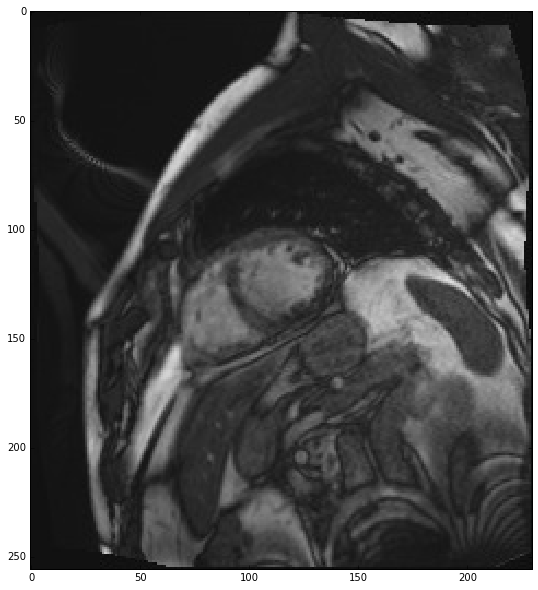

In [7]:
# Enter path to any image from the bucket used to compute the mean above
path_to_image = <enter_path_to_image>
image = caffe.io.load_image(path_to_image)
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [8]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[0] = transformed_image

### perform classification
output = net.forward()

In [9]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 224, 224)
conv1_1	(50, 64, 224, 224)
conv1_2	(50, 64, 224, 224)
pool1	(50, 64, 112, 112)
conv2_1	(50, 128, 112, 112)
conv2_2	(50, 128, 112, 112)
pool2	(50, 128, 56, 56)
conv3_1	(50, 256, 56, 56)
conv3_2	(50, 256, 56, 56)
conv3_3	(50, 256, 56, 56)
conv3_4	(50, 256, 56, 56)
pool3	(50, 256, 28, 28)
conv4_1	(50, 512, 28, 28)
conv4_2	(50, 512, 28, 28)
conv4_3	(50, 512, 28, 28)
conv4_4	(50, 512, 28, 28)
pool4	(50, 512, 14, 14)
conv5_1	(50, 512, 14, 14)
conv5_2	(50, 512, 14, 14)
conv5_3	(50, 512, 14, 14)
conv5_4	(50, 512, 14, 14)
pool5	(50, 512, 7, 7)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [10]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data); plt.axis('off')

(32, 32, 3)


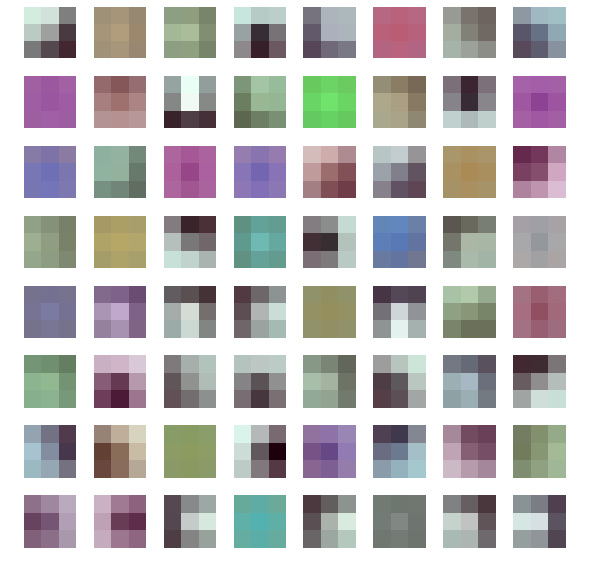

In [11]:
# the parameters are a list of [weights, biases]
# Visualize the filters at conv1_1 layer of the conv net
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

(1800, 1800)


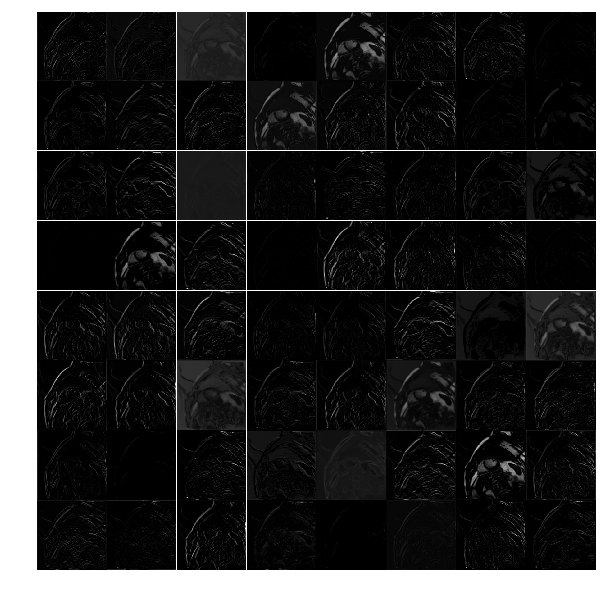

In [12]:
# Visualize the features extracted at conv1_2
# We see 64 different images, each an output of one of the 64 filters in conv1_2 layer.
feat = net.blobs['conv1_2'].data[0, :64]
vis_square(feat)

(345, 345)


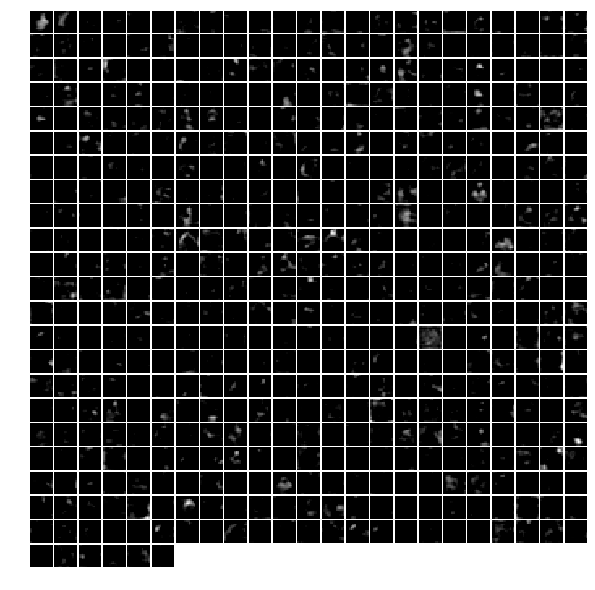

In [13]:
# We will extract features at conv5_4.
# 512 filters give rise to 512 (14x14) images of each input image
feat = net.blobs['conv5_4'].data[0]
vis_square(feat)

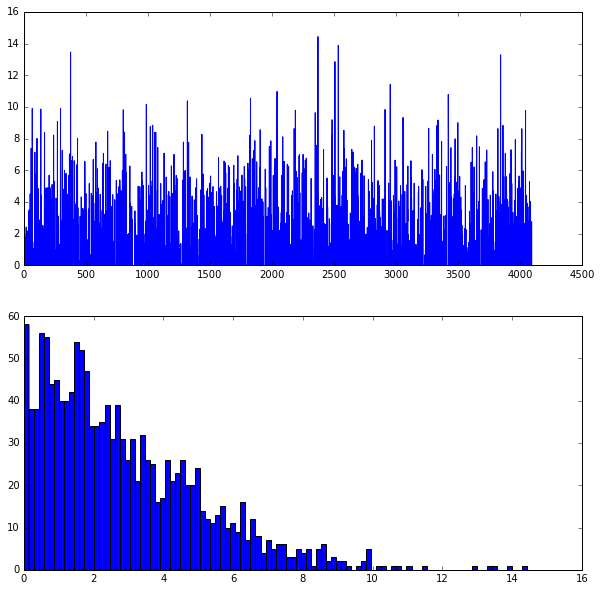

In [14]:
# Our feature extraction visualization ends in the cell above.
# But this and the next cell shows the spread of excitation in the fully connected layers
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

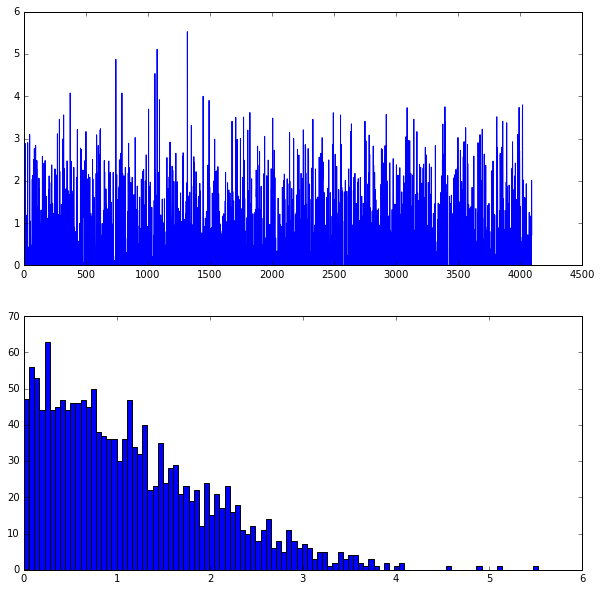

In [15]:
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

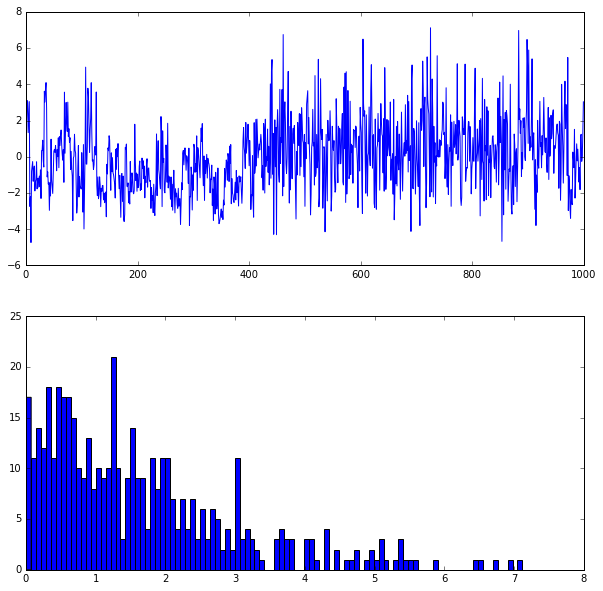

In [16]:
feat = net.blobs['fc8'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)